In [26]:
import matplotlib
# matplotlib.use("Agg")  # Use a non-interactive backend for matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import pickle
import scipy
from scipy.signal import butter


import sys
sys.path.append("/workspaces/src/rPPG-Toolbox")

import cv2
from PyEVM.facedetection import facedetectors
from PyEVM.gt_visualize import GTVisualizer
#from dataset.data_loader.BaseLoader import BaseLoader

video_path_to_use = "/mnt/data/vitalVideos/3cf596e2bcc34862abc89bd2eca4a985_1.mp4"
global_output_path = "videos/"

output_gifs = True

max_frame = 90
median_face_box_reinit = 30

In [27]:
def read_wave(bvp_file):
    """Reads a bvp signal file."""
    with open(bvp_file, "r") as f:
        str1 = f.read()
        str1 = str1.split("\n")
        bvp = [float(x) for x in str1[0].split()]
    return np.asarray(bvp)

In [28]:
def read_from_pickle_0_flat(data, data_to_load="predictions", normalize=True):

    if isinstance(data, str):
        with open(data, "rb") as f:
            data = pickle.load(f)

    data_dict = data[data_to_load]
    data_list = []

    for key in data_dict.keys():
        for i in range(len(data_dict[key])):
            curr_data = np.array(data_dict[key][i].cpu().numpy())

            if normalize:
                curr_data = (curr_data - np.mean(curr_data)) / np.std(curr_data)

            data_list.append(curr_data)

    return np.array(data_list).reshape(len(data_dict.keys()), 1, -1)

In [29]:
def get_large_face_box(face_box, factor=1.5):
    """Returns a larger face box by a given factor."""
    x, y, w, h = face_box
    new_w = int(w * factor)
    new_h = int(h * factor)
    new_x = max(0, x - (new_w - w) // 2)
    new_y = max(0, y - (new_h - h) // 2)
    return [new_x, new_y, new_w, new_h]

In [30]:
def read_video(video_file, max_frame=None):
    """Reads a video file, returns frames(T,H,W,3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()

    Idx = 0

    while (success):
        frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
        frame = np.asarray(frame)
        frame[np.isnan(frame)] = 0  # TODO: maybe change into avg
        frames.append(frame)
        success, frame = VidObj.read()
        Idx += 1

        if max_frame is not None and Idx >= max_frame:
            break

    return np.asarray(frames)

In [31]:

def write_video_0(frames, output_path, width, height, fps=30.0):
    fourcc = cv2.VideoWriter_fourcc(*'FFV1')  # FFV1 is a lossless codec supported by OpenCV/ffmpeg
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    for frame in frames:
        out.write(frame)
    
    out.release()
    print(f"Video saved to {output_path}")


In [32]:
def write_gif(frames, output_path, width, height, fps=30.0):
    """Writes frames to a GIF file."""
    for i in range(len(frames)):
        frames[i] = cv2.cvtColor(np.array(frames[i]), cv2.COLOR_BGR2RGB)
        frames[i] = cv2.resize(np.array(frames[i]), (width, height))

    imageio.mimsave(output_path, frames, format="GIF-PIL")
    print(f"GIF saved to {output_path}")

In [33]:
def write_video(frames, output_path, width, height, fps=30.0):
    if output_gifs:
        output_path = output_path + ".gif"
        write_gif(frames, output_path, width, height, fps)
    else:
        output_path = output_path + ".avi"
        write_video_0(frames, output_path, width, height, fps)

In [34]:

video_frames = []

face_detector = facedetectors.ViolaJonesFaceDetector()
cap = cv2.VideoCapture(video_path_to_use)
frame_count = 0


while cap.isOpened() and frame_count < max_frame:
    ret, frame = cap.read()
    if not ret or frame_count >= max_frame:
        break
    video_frames.append(frame)
    frame_count += 1

cap.release()

cropped_frames = []
frames_marked = []
faces = []

for i, frame in enumerate(video_frames):
    face = face_detector.detect_faces(frame)
    if face is not None:
        face = get_large_face_box(face)
        x, y, w, h = face
        new_frame = frame.copy()
        cv2.rectangle(new_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        frames_marked.append(new_frame)
    
    cropped = frame[y:y + h, x:x + w] if face is not None else frame
    cropped_frames.append(cropped)
    faces.append(face)

widths = [frame.shape[1] for frame in video_frames]
heights = [frame.shape[0] for frame in video_frames]



# Define output video path and parameters
output_video_cropped_path = os.path.join(global_output_path, "output_video_cropped")

# Assume video_frames is a list of frames (numpy arrays)
if not video_frames:
    raise ValueError("No frames to write to video.")

# Compute average width and height from frame sizes
heights = [frame.shape[0] for frame in cropped_frames]
widths = [frame.shape[1] for frame in cropped_frames]
avg_height = int(round(sum(heights) / len(heights)))
avg_width = int(round(sum(widths) / len(widths)))

write_video(cropped_frames, output_video_cropped_path, avg_width, avg_height)


GIF saved to videos/output_video_cropped.gif


In [35]:
output_video_path = os.path.join(global_output_path, "output_video_marked")

width = video_frames[0].shape[1]
height = video_frames[0].shape[0]
write_video(frames_marked, output_video_path, width, height)


GIF saved to videos/output_video_marked.gif


In [36]:
median_face_boxes = np.array(faces)
median_face_boxes = median_face_boxes.reshape(-1, median_face_box_reinit, 4)
median_face_boxes = np.median(median_face_boxes, axis=1)
median_face_boxes = np.reshape(median_face_boxes, (-1, 1, 4))
median_face_boxes = np.repeat(median_face_boxes, median_face_box_reinit, axis=1)
median_face_boxes = median_face_boxes.reshape(-1, 4)
median_face_boxes = median_face_boxes.astype(np.int32)

print(f"Median face boxes shape: {median_face_boxes.shape}")

median_face_box_frames = []
for i, frame in enumerate(video_frames):
    face_box = median_face_boxes[i]
    x, y, w, h = face_box
    new_frame = frame.copy()
    #cv2.rectangle(new_frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    new_frame = new_frame[y:y + h, x:x + w]
    new_frame = cv2.resize(new_frame, (median_face_boxes[0][2], median_face_boxes[0][3]))
    median_face_box_frames.append(new_frame)

write_video(median_face_box_frames, os.path.join(global_output_path, "output_video_median_face_boxes"), median_face_box_frames[0].shape[1], median_face_box_frames[0].shape[0])



Median face boxes shape: (90, 4)
GIF saved to videos/output_video_median_face_boxes.gif


In [56]:

correlation_face_detector = facedetectors.CorrelationFaceDetector(base_detector=face_detector)
correlation_frames = []
for i, frame in enumerate(video_frames):
    face = correlation_face_detector.detect_faces(frame)
    if face is not None:
        face = get_large_face_box(face)
        x, y, w, h = face
        new_frame = frame.copy()
        #cv2.rectangle(new_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        new_frame = new_frame[y:y + h, x:x + w]
        correlation_frames.append(new_frame)
    else:
        correlation_frames.append(frame)

write_video(correlation_frames, os.path.join(global_output_path, "output_video_correlation"), correlation_frames[0].shape[1], correlation_frames[0].shape[0])

GIF saved to videos/output_video_correlation.gif


In [57]:
optical_flow_face_detector = facedetectors.OpticalFlowFaceDetector(face_detector=face_detector)
optical_flow_frames = []
for i, frame in enumerate(video_frames):
    face = optical_flow_face_detector.detect_faces(frame)
    if face is not None:
        face = get_large_face_box(face)
        x, y, w, h = face
        new_frame = frame.copy()
        #cv2.rectangle(new_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        new_frame = new_frame[y:y + h, x:x + w]
        optical_flow_frames.append(new_frame)
    else:
        optical_flow_frames.append(frame)

write_video(optical_flow_frames, os.path.join(global_output_path, "output_video_optical_flow"), optical_flow_frames[0].shape[1], optical_flow_frames[0].shape[0])

GIF saved to videos/output_video_optical_flow.gif


In [58]:
mosse_face_detector = facedetectors.MOSSEFaceDetector(face_detector)
mosse_frames = []
for i, frame in enumerate(video_frames):
    face = mosse_face_detector.detect_faces(frame)
    if face is not None:
        face = get_large_face_box(face)
        x, y, w, h = face
        new_frame = frame.copy()
        #cv2.rectangle(new_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        new_frame = new_frame[y:y + h, x:x + w]
        mosse_frames.append(new_frame)
    else:
        mosse_frames.append(frame)

write_video(mosse_frames, os.path.join(global_output_path, "output_video_mosse"), mosse_frames[0].shape[1], mosse_frames[0].shape[0])

GIF saved to videos/output_video_mosse.gif


In [59]:
resized_frames = []
for i, frame in enumerate(correlation_frames):
    frame_resized = cv2.resize(frame, (72, 72))
    frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    resized_frames.append(frame_resized)

output_resized_video_path = os.path.join(global_output_path, "output_video_resized")
write_video(resized_frames, output_resized_video_path, 72, 72)

GIF saved to videos/output_video_resized.gif


In [64]:
resized_frames = []
for i, frame in enumerate(correlation_frames):
    frame_resized = cv2.resize(frame, (50, 50))
    frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    resized_frames.append(frame_resized)

output_resized_video_path = os.path.join(global_output_path, "output_video_resized_50")
write_video(resized_frames, output_resized_video_path, 50, 50)

GIF saved to videos/output_video_resized_50.gif


In [65]:
resized_frames = []
for i, frame in enumerate(correlation_frames):
    frame_resized = cv2.resize(frame, (20, 20))
    frame_resized = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    resized_frames.append(frame_resized)

output_resized_video_path = os.path.join(global_output_path, "output_video_resized_20")
write_video(resized_frames, output_resized_video_path, 20, 20)

GIF saved to videos/output_video_resized_20.gif


In [41]:
resized_frames = np.array(resized_frames).astype(np.float32)
print(f"Resized frames shape: {resized_frames.shape} - {resized_frames.dtype}")
diff_frames = np.diff(resized_frames, axis=0)
diff_frames = (diff_frames - np.min(diff_frames)) / (np.max(diff_frames) - np.min(diff_frames)) * 255.0
diff_frames = diff_frames.astype(np.uint8)

print(f"Diff frames shape: {diff_frames.shape} - {diff_frames.dtype}")
print(f"Diff frames min: {np.min(diff_frames)}, max: {np.max(diff_frames)}, mean: {np.mean(diff_frames)}, std: {np.std(diff_frames)}")

output_diff_normalized_video_path = os.path.join(global_output_path, "output_video_diff")
write_video(diff_frames, output_diff_normalized_video_path, 72, 72)

Resized frames shape: (90, 72, 72, 3) - float32
Diff frames shape: (89, 72, 72, 3) - uint8
Diff frames min: 0, max: 255, mean: 121.01790513594119, std: 3.2396092107522234
GIF saved to videos/output_video_diff.gif


In [42]:
def read_video(video_path):
    """Reads a video file and returns its frames."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

In [43]:
def shuffle_frames(arr):
    idx = np.arange(arr.shape[0])
    np.random.shuffle(idx)
    return arr[idx]

In [44]:
def video_to_BGR(frames):
    """Converts a list of frames to BGR format."""
    bgr_frames = []
    for frame in frames:
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        bgr_frames.append(bgr_frame)
    return bgr_frames

In [60]:
face_source = read_video("face_source.wmv")
face_result = read_video("face_result.wmv")

face_source = np.array(face_source)
face_result = np.array(face_result)

print(f"Face source shape: {face_source.shape}, dtype: {face_source.dtype}")
print(f"Face result shape: {face_result.shape}, dtype: {face_result.dtype}")

face_source_shuffled = shuffle_frames(face_source)
face_result_shuffled = shuffle_frames(face_result)

#face_source_shuffled = video_to_BGR(face_source_shuffled)
#face_result_shuffled = video_to_BGR(face_result_shuffled)

write_video(face_source_shuffled, os.path.join(global_output_path, "face_source_shuffled"), face_source[0].shape[1], face_source[0].shape[0])
write_video(face_result_shuffled, os.path.join(global_output_path, "face_result_shuffled"), face_result[0].shape[1], face_result[0].shape[0])

Face source shape: (301, 600, 528, 3), dtype: uint8
Face result shape: (301, 600, 528, 3), dtype: uint8
GIF saved to videos/face_source_shuffled.gif
GIF saved to videos/face_result_shuffled.gif


GIF saved to videos/ubfc_video.gif


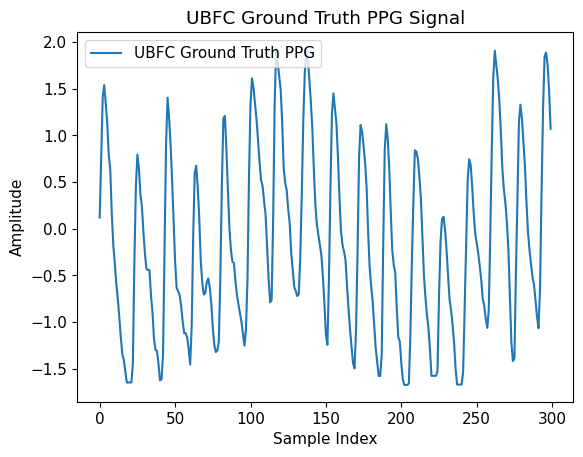

In [62]:
%matplotlib inline

sampling_rate = 30.0  # Assuming a sampling rate of 30 Hz

ubfc_example_directory = "/mnt/data/ubfc/subject1"
ubfc_video_path = os.path.join(ubfc_example_directory, "vid.avi")
ubfc_bvp_path = os.path.join(ubfc_example_directory, "ground_truth.txt")

ubfc_video_frames = read_video(ubfc_video_path)
ubfc_bvp = read_wave(ubfc_bvp_path)

video_to_save = ubfc_video_frames[:30]
#video_to_save = video_to_BGR(video_to_save)

write_video(video_to_save, os.path.join(global_output_path, "ubfc_video"), ubfc_video_frames[0].shape[1], ubfc_video_frames[0].shape[0])
plt.plot(ubfc_bvp[:int(sampling_rate * 10)], label='UBFC Ground Truth PPG')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('UBFC Ground Truth PPG Signal')
plt.legend()
plt.show()

The predicted timestamps are longer than the PPG values. Truncating the predicted timestamps.


GIF saved to videos/vv_video.gif


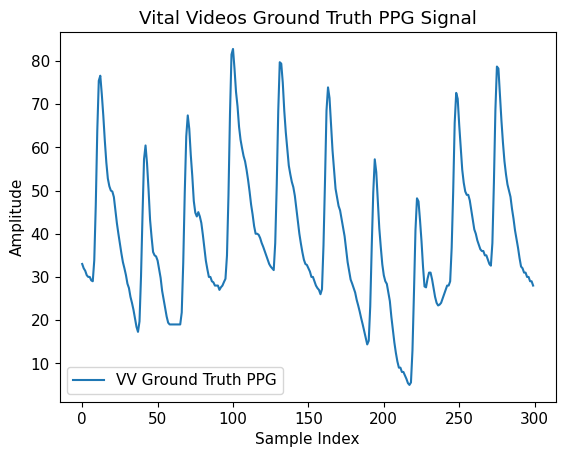

In [63]:
%matplotlib inline

sampling_rate = 30.0  # Assuming a sampling rate of 30 Hz

vv_video_path = "/mnt/data/vitalVideos/3cf596e2bcc34862abc89bd2eca4a985_1.mp4"
vv_json_path = vv_video_path.split("_")[0] + ".json"

vv_video_frames = read_video(vv_video_path)
vv_video_frames = np.array(vv_video_frames)

gt_visualizer = GTVisualizer(vv_json_path, vv_video_path)
dummy_ppg = np.zeros((vv_video_frames.shape[0]))
time, ppg, _ = gt_visualizer.resample_ppg(dummy_ppg, num_frames=vv_video_frames.shape[0])

video_to_save = vv_video_frames[:30]
#video_to_save = video_to_BGR(video_to_save)

write_video(video_to_save, os.path.join(global_output_path, "vv_video"), vv_video_frames[0].shape[1], vv_video_frames[0].shape[0])
plt.plot(ppg[:int(sampling_rate * 10)], label='VV Ground Truth PPG')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Vital Videos Ground Truth PPG Signal')
plt.legend()
plt.show()

In [52]:
def visualize_preprocessed_video(video_path, ppg_path, sampling_rate=30.0, output_path="visualized_video.mp4", channels="diff_channels"):
    """
    Visualizes a preprocessed video with the corresponding PPG signal.
    
    Args:
        video_frames (list of np.ndarray): List of video frames.
        ppg_signal (np.ndarray): Corresponding PPG signal.
        sampling_rate (float): Sampling rate of the PPG signal.
    """
    vv_video_frames = np.load(video_path, allow_pickle=True)['array1']
    ppg_signal = np.load(ppg_path, allow_pickle=True)['array1']

    if channels == "diff_channels":
        vv_video_frames = vv_video_frames[:, :, :, 0:3]  # Use only RGB channels
    else:
        vv_video_frames = vv_video_frames[:, :, :, 3:6]  # Use only the last 3 channels

    vv_video_frames = (vv_video_frames - np.min(vv_video_frames)) / (np.max(vv_video_frames) - np.min(vv_video_frames)) * 255.0
    vv_video_frames = vv_video_frames.astype(np.uint8)

    # Normalize PPG signal between 0 and 1
    ppg_signal = (ppg_signal - np.min(ppg_signal)) / (np.max(ppg_signal) - np.min(ppg_signal))

    for i in range(len(vv_video_frames)):
        curr_rect_value = ppg_signal[i] * 255.0  # Scale PPG value to [0, 255]
        curr_rect_value = int(curr_rect_value)

        cv2.rectangle(vv_video_frames[i], (0, 0), (5, 5), (curr_rect_value, curr_rect_value, curr_rect_value), -1)

    # Write the video with rectangles
    write_video(vv_video_frames, output_path, vv_video_frames[0].shape[1], vv_video_frames[0].shape[0], fps=sampling_rate)

In [53]:
vv_preprcessed = "/mnt/results/preprocessed_rppgToolbox/VitalVideos_SizeW72_SizeH72_ClipLength450_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxTrue_DNone_amp10.0"
video_path = os.path.join(vv_preprcessed, "41_input0.npy.compressed.npz")
ppg_path = os.path.join(vv_preprcessed, "41_label0.npy.compressed.npz")

visualize_preprocessed_video(video_path, ppg_path, sampling_rate=30.0, output_path=os.path.join(global_output_path, "vv_visualized_preprocessed_video"))

GIF saved to videos/vv_visualized_preprocessed_video.gif


In [54]:
emergency_preprcessed = "/mnt/results/preprocessed_rppgToolbox/emergency/Emergency_Videos_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendY5F_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len30_Median_face_boxFalse_DNone_amp10.0V_0.0_9999.0"
video_path = os.path.join(emergency_preprcessed, "1_input1.npy.compressed.npz")
ppg_path = os.path.join(emergency_preprcessed, "1_label1.npy.compressed.npz")

visualize_preprocessed_video(video_path, ppg_path, sampling_rate=30.0, output_path=os.path.join(global_output_path, "emergency_visualized_preprocessed_video"))

GIF saved to videos/emergency_visualized_preprocessed_video.gif


In [55]:
emergency_preprcessed = "/mnt/results/preprocessed_rppgToolbox/emergency/Emergency_Videos_SizeW72_SizeH72_ClipLength160_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendCORRYU_Large_boxTrue_Large_size1.5_Dyamic_DetTrue_det_len1_Median_face_boxFalse_DNone_amp10.0V_0.0_9999.0"
video_path = os.path.join(emergency_preprcessed, "0_input0.npy.compressed.npz")
ppg_path = os.path.join(emergency_preprcessed, "0_label0.npy.compressed.npz")

visualize_preprocessed_video(video_path, ppg_path, sampling_rate=30.0, output_path=os.path.join(global_output_path, "emergency_visualized_preprocessed_video"))

GIF saved to videos/emergency_visualized_preprocessed_video.gif
